In [32]:
# Import libraries
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm


import warnings
warnings.filterwarnings('ignore')

In [33]:
# Defaults
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams.update({'font.size': 12})
plt.style.use('ggplot')

In [34]:
# Load data
data = pd.read_csv('Monthly Total A&E Attendances.ARIMA.csv', engine='python', skipfooter=3)

In [35]:
# Checking data types and info
data.info()
data.dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Month                  110 non-null    object
 1   Total A&E Attendances  110 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 1.8+ KB


Month                    object
Total A&E Attendances     int64
dtype: object

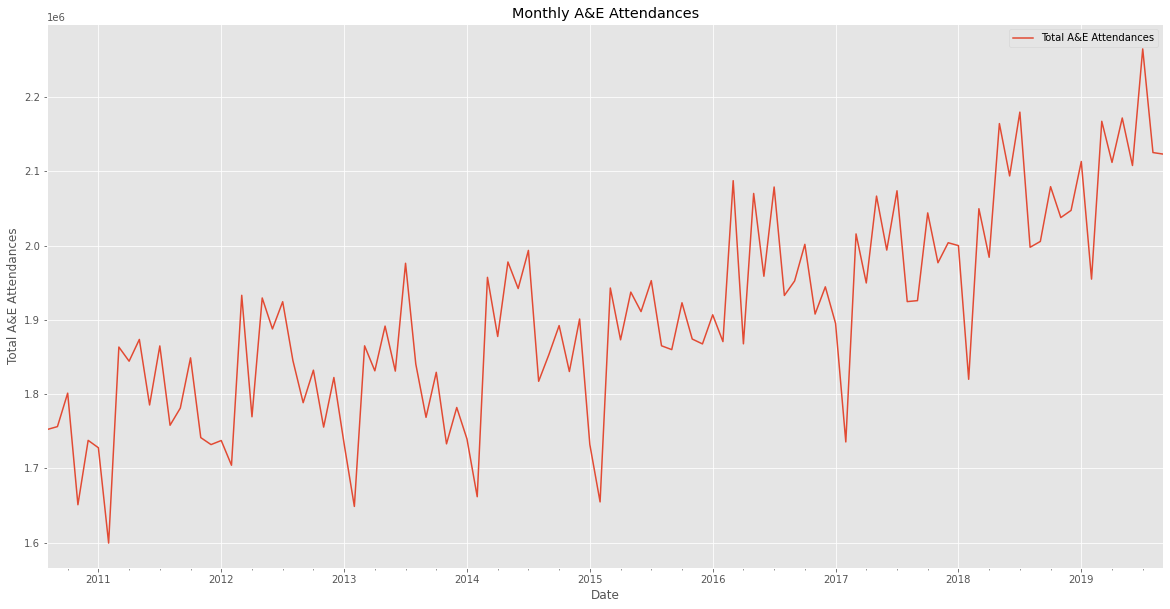

In [36]:
# pre-processing
data['Month']=pd.to_datetime(data['Month'], format='%Y-%m-%d')
data.set_index(['Month'], inplace=True)

# Plot data
data.plot()
plt.title('Monthly A&E Attendances')
plt.ylabel('Total A&E Attendances')
plt.xlabel('Date')
plt.show()

<Figure size 1440x720 with 0 Axes>

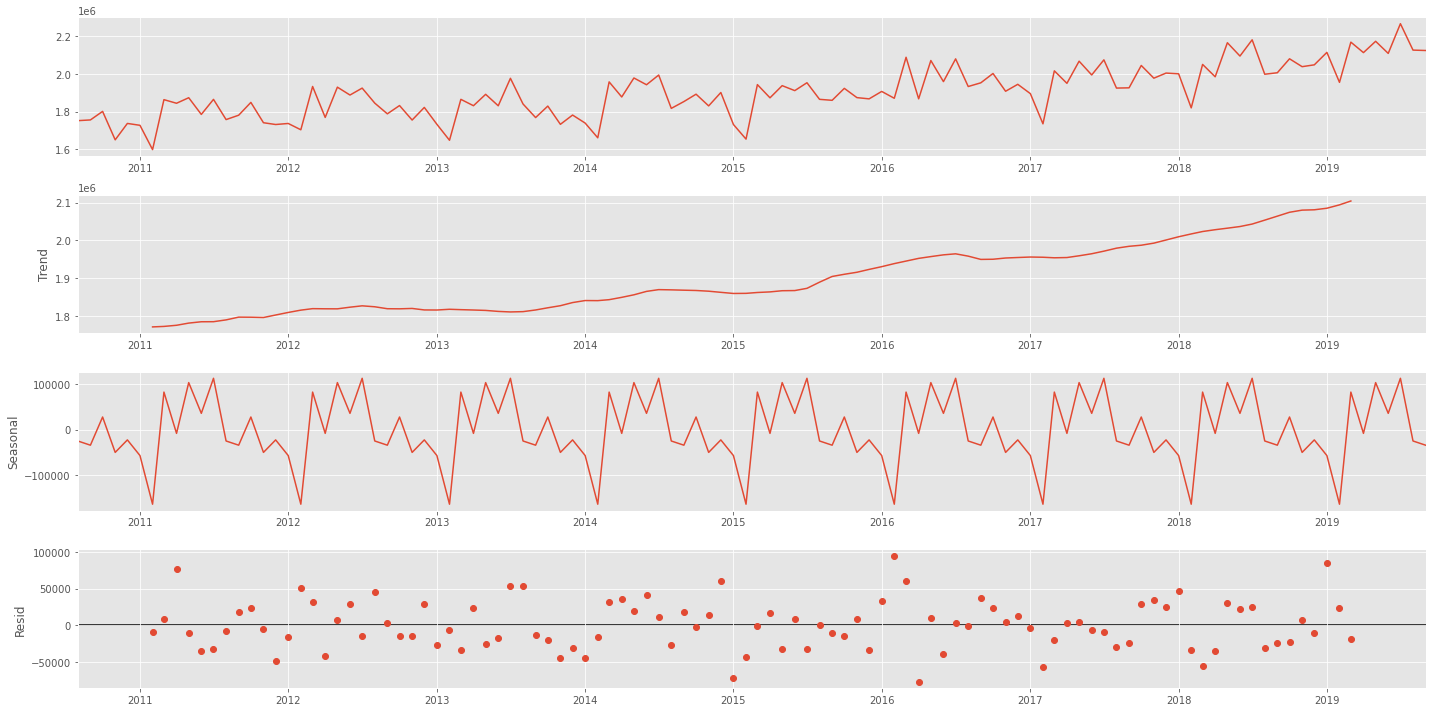

In [37]:
# Decomposing and plotting the ACF to check for trend, seasonality and see if the data is stationary

from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(data)
fig = plt.figure()
fig = decomposition.plot()

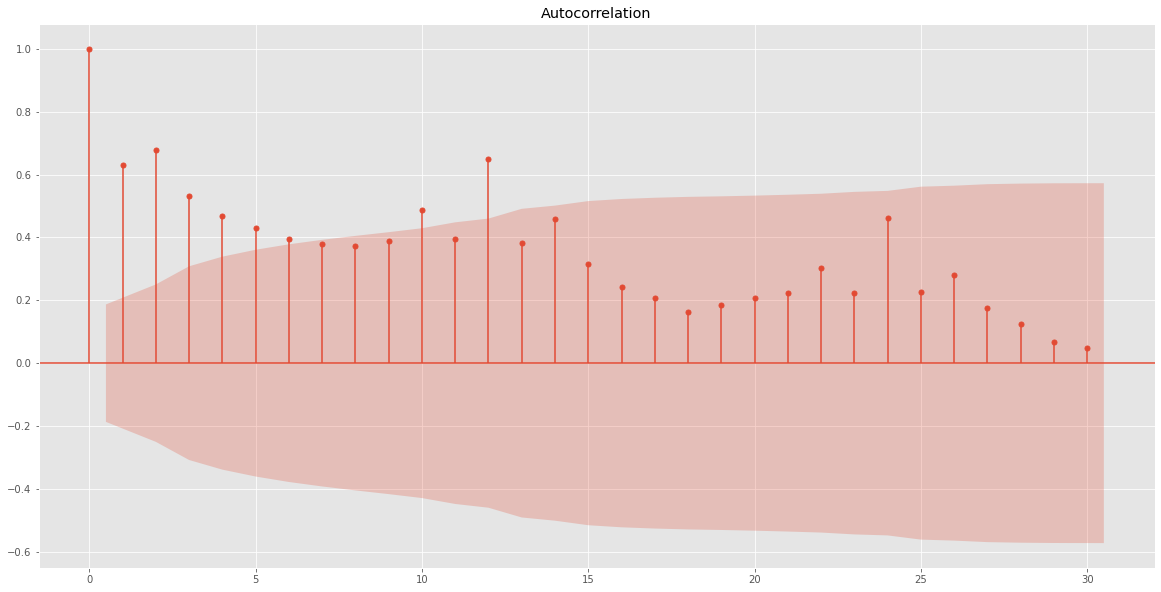

In [38]:
# Decomposing and plotting the ACF to check for trend, seasonality and see if the data is stationary

from statsmodels.graphics.tsaplots import plot_acf
plot_acf(data['Total A&E Attendances'], lags=30);

In [39]:
# Difference once

data.diff(1).dropna()

,Total A&E Attendances
Month,
2010-09-01,3887.0
2010-10-01,45080.0
2010-11-01,-150321.0
2010-12-01,86714.0
2011-01-01,-9944.0
...,...
2019-05-01,59841.0
2019-06-01,-64019.0
2019-07-01,157063.0


In [40]:
# Define the d and q parameters to take any value between 0 and 1
q = d = range(0, 2)
# Define the p parameters to take any value between 0 and 3
p = range(0, 4)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Grid Search / Hyperparameter Optimization for Model selection - (be able to pick up the smallest AIC Value).
# Generate all different combinations of seasonal p, q and q
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

# SARIMAX returns the AIC Value
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [41]:
data

,Total A&E Attendances
Month,
2010-08-01,1752381
2010-09-01,1756268
2010-10-01,1801348
2010-11-01,1651027
2010-12-01,1737741
...,...
2019-05-01,2172006
2019-06-01,2107987
2019-07-01,2265050


In [47]:
# Train test split
training_data = data['2010-08-01':'2016-12-01']
test_data = data['2017-01-01':'2019-12-01']

In [43]:
# Generate an AIC Value
AIC = []
SARIMAX_model = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(training_data,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic), end='\r')
            AIC.append(results.aic)
            SARIMAX_model.append([param, param_seasonal])
        except:
            continue
results

In [44]:
mod = sm.tsa.statespace.SARIMAX(training_data,
                                order=param,
                                seasonal_order=param_seasonal,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic), end='\r')
AIC.append(results.aic)
SARIMAX_model.append([param, param_seasonal])

In [45]:
print('The smallest AIC is {} for model SARIMAX{}x{}'.format(min(AIC), SARIMAX_model[AIC.index(min(AIC))][0],SARIMAX_model[AIC.index(min(AIC))][1]))


The smallest AIC is 623.7836379365564 for model SARIMAX(3, 1, 0)x(3, 1, 0, 12)


In [46]:
# Fit the model
mod = sm.tsa.statespace.SARIMAX(training_data,
                                order=SARIMAX_model[AIC.index(min(AIC))][0],
                                seasonal_order=SARIMAX_model[AIC.index(min(AIC))][1],
                                enforce_stationarity=False,
                                enforce_invertibility=False) #pdq order kept the same

results = mod.fit()

In [48]:
# Sample prediction with 1-step ahead forecasting of the last year 2018  
# Model is asked to predict data using existing data 

pred1 = results.get_prediction(start='2019-01-01')
pred1_ci = pred1.conf_int()

In [49]:
# True forecasting 
# Model is asked to predict data its not seen before 

pred2 = results.get_forecast('2020-12-01')
pred2_ci = pred2.conf_int()
print(pred2.predicted_mean['2010-08-01':'2019-12-01'])

2017-01-01    1.845573e+06
2017-02-01    1.760338e+06
2017-03-01    1.998032e+06
2017-04-01    1.969701e+06
2017-05-01    2.020815e+06
2017-06-01    1.976842e+06
2017-07-01    2.087501e+06
2017-08-01    1.964274e+06
2017-09-01    1.910146e+06
2017-10-01    1.971169e+06
2017-11-01    1.890837e+06
2017-12-01    1.926287e+06
2018-01-01    1.904835e+06
2018-02-01    1.840108e+06
2018-03-01    2.117919e+06
2018-04-01    1.992587e+06
2018-05-01    2.125471e+06
2018-06-01    2.068968e+06
2018-07-01    2.133824e+06
2018-08-01    1.967037e+06
2018-09-01    2.004559e+06
2018-10-01    2.046075e+06
2018-11-01    1.977538e+06
2018-12-01    2.036589e+06
2019-01-01    1.887289e+06
2019-02-01    1.809268e+06
2019-03-01    2.078736e+06
2019-04-01    2.016452e+06
2019-05-01    2.079400e+06
2019-06-01    2.045160e+06
2019-07-01    2.110124e+06
2019-08-01    2.016006e+06
2019-09-01    1.993825e+06
2019-10-01    2.057593e+06
2019-11-01    1.998394e+06
2019-12-01    2.000427e+06
Freq: MS, Name: predicted_me

In [50]:
pred2_rmse = results.predict(start='2017-01-01', end= '2019-09-01')

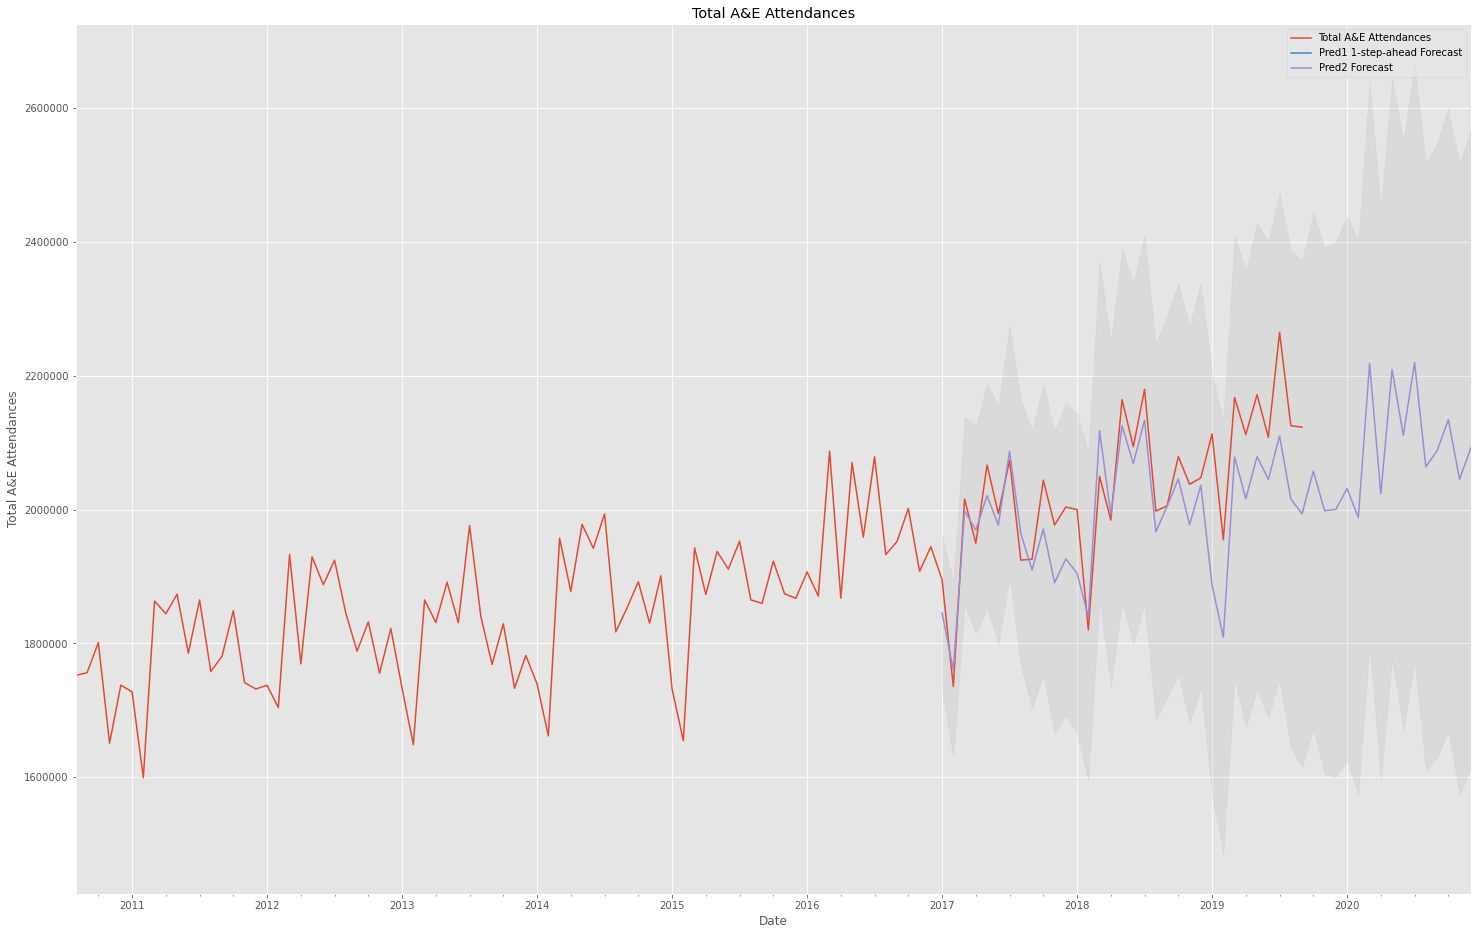

In [54]:
# Plot all data

ax = data.plot(figsize=(25, 16))
pred1.predicted_mean.plot(ax=ax, label='Pred1 1-step-ahead Forecast')
pred2.predicted_mean.plot(ax=ax, label='Pred2 Forecast')
ax.fill_between(pred2_ci.index, pred2_ci.iloc[:, 0], pred2_ci.iloc[:, 1], color='grey', alpha=.1)
plt.title('Total A&E Attendances')
plt.ylabel('Total A&E Attendances')
plt.xlabel('Date')
plt.ticklabel_format(style='plain', axis='y')
plt.legend()
plt.show()

In [55]:
# RMSE

from sklearn.metrics import mean_squared_error
from math import sqrt


rms_sarima = sqrt(mean_squared_error(test_data, pred2_rmse))
print(rms_sarima)

78997.40936572876
